Probability of Default Model Demo

Generating sample credit data...
Dataset shape: (2000, 11)
Default rate: 87.75%

Preparing data...
Training model...
Model trained successfully using logistic

Model Evaluation - LOGISTIC

AUC-ROC Score: 0.7880

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

  No Default       0.33      0.04      0.07        74
     Default       0.88      0.99      0.93       526

    accuracy                           0.87       600
   macro avg       0.61      0.51      0.50       600
weighted avg       0.81      0.87      0.83       600


Confusion Matrix:
[[  3  71]
 [  6 520]]


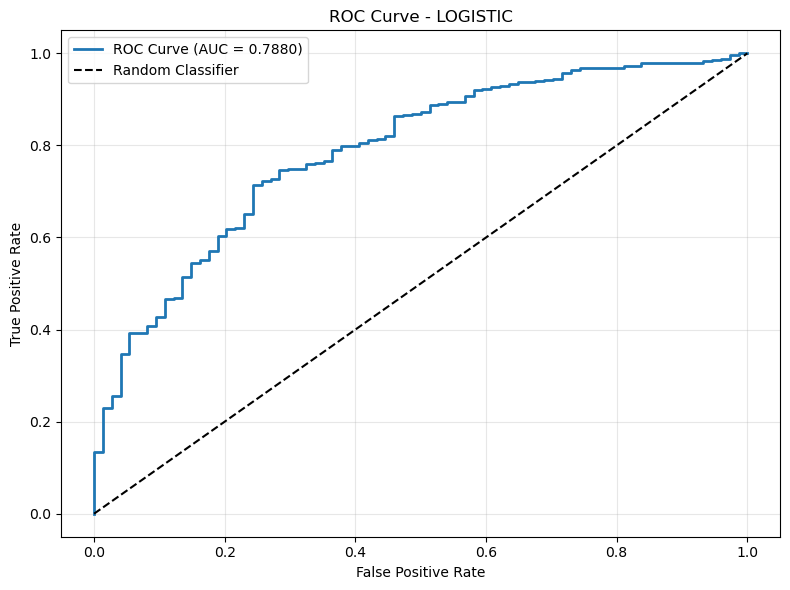

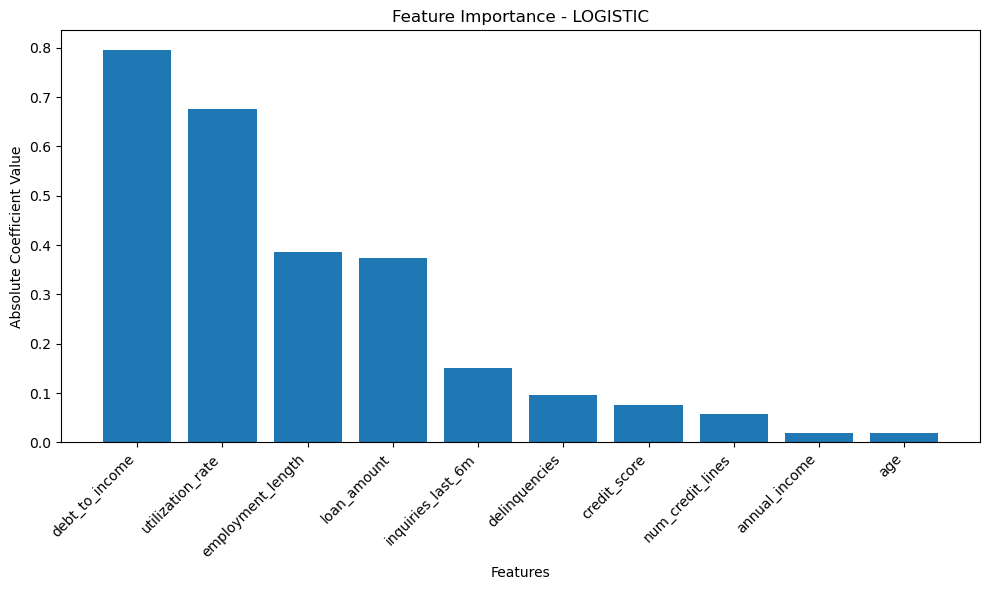


Example Prediction for New Customer
Probability of Default: 95.27%
Risk Category: High Risk


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report, 
                             confusion_matrix, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

class ProbabilityOfDefaultModel:
    """
    A comprehensive Probability of Default (PD) model for credit risk assessment.
    Supports multiple algorithms and provides extensive evaluation metrics.
    """
    
    def __init__(self, model_type='logistic'):
        """
        Initialize the PD model.
        
        Parameters:
        -----------
        model_type : str
            Type of model to use: 'logistic', 'random_forest', or 'gradient_boosting'
        """
        self.model_type = model_type
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = None
        
        # Initialize model based on type
        if model_type == 'logistic':
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model_type == 'gradient_boosting':
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("model_type must be 'logistic', 'random_forest', or 'gradient_boosting'")
    
    def generate_sample_data(self, n_samples=1000):
        """
        Generate synthetic credit data for demonstration purposes.
        
        Parameters:
        -----------
        n_samples : int
            Number of samples to generate
            
        Returns:
        --------
        pd.DataFrame : Generated dataset with features and default indicator
        """
        data = {
            'credit_score': np.random.normal(650, 100, n_samples),
            'debt_to_income': np.random.uniform(0.1, 0.6, n_samples),
            'loan_amount': np.random.uniform(5000, 100000, n_samples),
            'employment_length': np.random.randint(0, 30, n_samples),
            'num_credit_lines': np.random.randint(1, 20, n_samples),
            'utilization_rate': np.random.uniform(0, 1, n_samples),
            'age': np.random.randint(18, 70, n_samples),
            'annual_income': np.random.uniform(20000, 150000, n_samples),
            'delinquencies': np.random.poisson(0.5, n_samples),
            'inquiries_last_6m': np.random.poisson(1, n_samples)
        }
        
        df = pd.DataFrame(data)
        
        # Generate default indicator based on features (with some noise)
        default_score = (
            -0.01 * df['credit_score'] +
            50 * df['debt_to_income'] +
            0.0001 * df['loan_amount'] +
            -0.5 * df['employment_length'] +
            30 * df['utilization_rate'] +
            5 * df['delinquencies'] +
            2 * df['inquiries_last_6m'] +
            np.random.normal(0, 10, n_samples)
        )
        
        # Convert to probability and then binary outcome
        prob = 1 / (1 + np.exp(-default_score / 10))
        df['default'] = (np.random.random(n_samples) < prob).astype(int)
        
        return df
    
    def prepare_data(self, df, target_col='default', test_size=0.3):
        """
        Prepare data for model training.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Input dataset
        target_col : str
            Name of the target column
        test_size : float
            Proportion of data to use for testing
            
        Returns:
        --------
        tuple : X_train, X_test, y_train, y_test
        """
        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        self.feature_names = X.columns.tolist()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train(self, X_train, y_train):
        """
        Train the PD model.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        """
        self.model.fit(X_train, y_train)
        print(f"Model trained successfully using {self.model_type}")
    
    def predict_proba(self, X):
        """
        Predict probability of default.
        
        Parameters:
        -----------
        X : array-like
            Features for prediction
            
        Returns:
        --------
        array : Probability of default (class 1)
        """
        return self.model.predict_proba(X)[:, 1]
    
    def evaluate(self, X_test, y_test, threshold=0.5):
        """
        Evaluate model performance.
        
        Parameters:
        -----------
        X_test : array-like
            Test features
        y_test : array-like
            Test labels
        threshold : float
            Classification threshold
            
        Returns:
        --------
        dict : Dictionary containing evaluation metrics
        """
        # Get predictions
        y_pred_proba = self.predict_proba(X_test)
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\n{'='*50}")
        print(f"Model Evaluation - {self.model_type.upper()}")
        print(f"{'='*50}")
        print(f"\nAUC-ROC Score: {auc_score:.4f}")
        print(f"\nClassification Report (threshold={threshold}):")
        print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        return {
            'auc_score': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': cm
        }
    
    def plot_roc_curve(self, X_test, y_test):
        """Plot ROC curve."""
        y_pred_proba = self.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {self.model_type.upper()}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance (for tree-based models)."""
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(importances)), importances[indices])
            plt.xticks(range(len(importances)), 
                      [self.feature_names[i] for i in indices], 
                      rotation=45, ha='right')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title(f'Feature Importance - {self.model_type.upper()}')
            plt.tight_layout()
            plt.show()
        elif hasattr(self.model, 'coef_'):
            coefs = np.abs(self.model.coef_[0])
            indices = np.argsort(coefs)[::-1]
            
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(coefs)), coefs[indices])
            plt.xticks(range(len(coefs)), 
                      [self.feature_names[i] for i in indices], 
                      rotation=45, ha='right')
            plt.xlabel('Features')
            plt.ylabel('Absolute Coefficient Value')
            plt.title(f'Feature Importance - {self.model_type.upper()}')
            plt.tight_layout()
            plt.show()


# Example usage
if __name__ == "__main__":
    print("Probability of Default Model Demo\n")
    
    # Create model instance
    pd_model = ProbabilityOfDefaultModel(model_type='logistic')
    
    # Generate sample data
    print("Generating sample credit data...")
    df = pd_model.generate_sample_data(n_samples=2000)
    print(f"Dataset shape: {df.shape}")
    print(f"Default rate: {df['default'].mean():.2%}\n")
    
    # Prepare data
    print("Preparing data...")
    X_train, X_test, y_train, y_test = pd_model.prepare_data(df)
    
    # Train model
    print("Training model...")
    pd_model.train(X_train, y_train)
    
    # Evaluate model
    results = pd_model.evaluate(X_test, y_test, threshold=0.5)
    
    # Plot ROC curve
    pd_model.plot_roc_curve(X_test, y_test)
    
    # Plot feature importance
    pd_model.plot_feature_importance()
    
    # Example prediction for a new customer
    print("\n" + "="*50)
    print("Example Prediction for New Customer")
    print("="*50)
    new_customer_df = pd.DataFrame(
    [[680, 0.35, 50000, 5, 8, 0.45, 35, 75000, 1, 2]],
    columns=pd_model.feature_names
)

    new_customer_scaled = pd_model.scaler.transform(new_customer_df)
    pd_prob = pd_model.predict_proba(new_customer_scaled)[0]

    print(f"Probability of Default: {pd_prob:.2%}")
    print(f"Risk Category: {'High Risk' if pd_prob > 0.3 else 'Medium Risk' if pd_prob > 0.1 else 'Low Risk'}")
